## **3-Link Manipulator**
---

>## Inequality constraints on 3-link
- **Goal**: Satisfies two equality constraints and four inequality constraints
$$
Horizontal\ stretch: L_1*cos(\theta_1) + L_2*cos(\theta_1+\theta_2) + L_3*cos(\theta_1+\theta_2+\theta_3) = 2.5\\
Vertical\ stretch: L_1*sin(\theta_1) + L_2*sin(\theta_1+\theta_2) + L_3*sin(\theta_1+\theta_2+\theta_3) = 0.75\\
First\ link's\ height: 0.1 \le L_1*sin(\theta_1) \le 0.95 \\
Second\ link's\ height: 0.1 \le L_2*sin(\theta_1+\theta_2) \le 0.95
$$
    

Packages used:
<span style="color:yellow; background-color:green">Plots, JuMP, Ipopt</span>

In [14]:
using Plots, JuMP, Ipopt
include("src/manipulator_library.jl")
include("src/plot_library.jl")

plot_points (generic function with 1 method)

In [11]:
params = modelParameters()
model = Model(Ipopt.Optimizer)

set_optimizer_attribute(model, "print_level", 1)
set_optimizer_attribute(model, "max_iter", 1000)
set_optimizer_attribute(model, "tol", 1e-9)

@variable(model, -pi<= th1 <=pi)
@variable(model, -pi<= th2 <=pi)
@variable(model, -pi<= th3 <=pi)

@constraint(model, g1, params.L1*cos(th1) + params.L2*cos(th1+th2) + params.L3*cos(th1+th2+th3) -2.5 == 0)
@constraint(model, g2, params.L1*sin(th1) + params.L2*sin(th1+th2) + params.L3*sin(th1+th2+th3) -0.75 == 0)   

use_inequality_constraints = true
if use_inequality_constraints
    @constraint(model, g3, params.L1*sin(th1) <= 0.95)
    @constraint(model, g4, params.L1*sin(th1) + params.L2*sin(th1 + th2) <= 0.95)
    @constraint(model, g5, params.L1*sin(th1) >=0.1)
    @constraint(model, g6, params.L1*sin(th1) + params.L2*sin(th1 + th2) >=0.1)
end

@objective(model, Min, th1^2 + th2^2 + th3^2)
optimize!(model)

With Inequality Constraints
Objective value: 6.812490744951165
Solution: 
th1Star = 0.05002085181111906
th2Star = 0.1881522921510836
th3Star = 2.6028037525509964
 


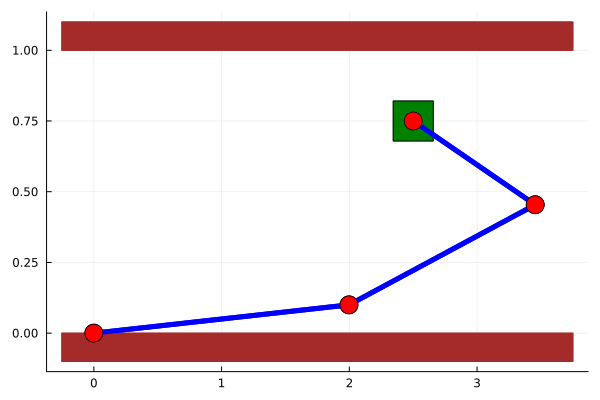

In [13]:
# Display the results
label = use_inequality_constraints ? "With Inequality Constraints" : "No Inequality Constraints"
println(label) 
println("Objective value: ", objective_value(model))
println("Solution: ")
println("th1Star = ", value(th1))
println("th2Star = ", value(th2))
println("th3Star = ", value(th3))
println(" ")            
positions = linkPositions(value(th1), value(th2), value(th3))
plot_points(positions, label)

>## $Dynamics\ a\ la\ Lagrange$ - Mass inertia matrix

- **Goal**: Find the Potential Energy and Kinetic Energy of the n-link manipulator
$$
PE = \int_{i=1}^n m_i*g*y_i\\
{}\\
KE = \int_{i=1}^n \frac{1}{2} * m_i * v_i^2
$$

- **Special Formula for any robot comprised of rigid links**: KE and Mass Inertia Matrix D(q)
$$
KE(q,\dot{q}) = \frac{1}{2} * \dot{q}^T * D(q) * \dot{q}\\
{}\\
D(q) = \frac{\partial}{\partial \dot{q}} \left[ \left( \frac{\partial}{\partial \dot{q}} KE(q, \dot{q}) \right)^\top \right]
$$

Packages used:
<span style="color:yellow; background-color:green">Symbolics, SymPy, Latexify</span>

In [39]:
using Symbolics, SymPy, Latexify
include("src/manipulator_library.jl")

simple (generic function with 1 method)

In [ ]:
#================================== TWO LINK MANIPULATOR =============================================#
set_default(fmt = "%.1f", convert_unicode = false)

@Symbolics.variables q1 q2 dq1 dq2 g m1 m2 L1 L2
q = [q1, q2]
dq = [dq1, dq2]

# Kinematics
p1 = [L1*cos(q1), L1*sin(q1)]
p2 = p1 + [L2*cos(q1 + q2), L2*sin(q1 + q2)]
v1 = Symbolics.jacobian(p1, q)*dq
v2 = Symbolics.jacobian(p2, q)*dq

# Potential energy
PE = m1*g*p1[2] + m2*g*p2[2]
PE = simple(PE)
println("Potential Energy: ", PE)

# Kinetic energy
KE1 = 0.5*m1*sum(v1.*v1)
KE2 = 0.5*m2*sum(v2.*v2)
KE = KE1 + KE2

D = Symbolics.hessian(KE, dq)
D = simple(D)
@show D

Potential Energy: g*(L1*m1*sin(q1) + m2*(L1*sin(q1) + L2*sin(q1 + q2)))
D = Any["L1^2*m1 + m2*(L1^2 + 2*L1*L2*cos(q2) + L2^2)" "L2*m2*(L1*cos(q2) + L2)"; "L2*m2*(L1*cos(q2) + L2)" "L2^2*m2"]


2×2 Matrix{Any}:
 "L1^2*m1 + m2*(L1^2 + 2*L1*L2*cos(q2) + L2^2)"  "L2*m2*(L1*cos(q2) + L2)"
 "L2*m2*(L1*cos(q2) + L2)"                       "L2^2*m2"

In [42]:
#====================================== THREE LINK MANIPULATOR ============================================#
@Symbolics.variables q1 q2 q3 dq1 dq2 dq3 g m1 m2 m3 L1 L2 L3
q = [q1, q2, q3]
dq = [dq1, dq2, dq3]

# Kinematics
p1 = [L1*cos(q1), L1*sin(q1)]
p2 = p1 + [L2*cos(q1 + q2), L2*sin(q1 + q2)]
p3 = p2 + [L3*cos(q1 + q2 + q3), L3*sin(q1 + q2 + q3)]
v1 = Symbolics.jacobian(p1, q)*dq
v2 = Symbolics.jacobian(p2, q)*dq
v3 = Symbolics.jacobian(p3, q)*dq

# Potential energy
PE = m1*g*p1[2] + m2*g*p2[2] + m3*g*p3[2]
PE = simple(PE)
println("Potential Energy: ", PE)

# Kinetic energy
KE1 = 0.5*m1*sum(v1.*v1)
KE2 = 0.5*m2*sum(v2.*v2)
KE3 = 0.5*m3*sum(v3.*v3)
KE = KE1 + KE2 + KE3

D = Symbolics.hessian(KE, dq)
D = simple(D)
@show D

Potential Energy: g*(L1*m1*sin(q1) + m2*(L1*sin(q1) + L2*sin(q1 + q2)) + m3*(L1*sin(q1) + L2*sin(q1 + q2) + L3*sin(q1 + q2 + q3)))
D = Any["L1^2*m1 + m2*(L1^2 + 2*L1*L2*cos(q2) + L2^2) + m3*(L1^2 + 2*L1*L2*cos(q2) + 2*L1*L3*cos(q2 + q3) + L2^2 + 2*L2*L3*cos(q3) + L3^2)" "L2*m2*(L1*cos(q2) + L2) + m3*(L1*L2*cos(q2) + L1*L3*cos(q2 + q3) + L2^2 + 2*L2*L3*cos(q3) + L3^2)" "L3*m3*(L1*cos(q2 + q3) + L2*cos(q3) + L3)"; "L2*m2*(L1*cos(q2) + L2) + m3*(L1*L2*cos(q2) + L1*L3*cos(q2 + q3) + L2^2 + 2*L2*L3*cos(q3) + L3^2)" "L2^2*m2 + m3*(L2^2 + 2*L2*L3*cos(q3) + L3^2)" "L3*m3*(L2*cos(q3) + L3)"; "L3*m3*(L1*cos(q2 + q3) + L2*cos(q3) + L3)" "L3*m3*(L2*cos(q3) + L3)" "L3^2*m3"]


3×3 Matrix{Any}:
 "L1^2*m1 + m2*(L1^2 + 2*L1*L2*co" ⋯ 67 bytes ⋯ " L2^2 + 2*L2*L3*cos(q3) + L3^2)"  …  "L3*m3*(L1*cos(q2 + q3) + L2*cos(q3) + L3)"
 "L2*m2*(L1*cos(q2) + L2) + m3*(L" ⋯ 35 bytes ⋯ " L2^2 + 2*L2*L3*cos(q3) + L3^2)"                                     "L3*m3*(L2*cos(q3) + L3)"
 "L3*m3*(L1*cos(q2 + q3) + L2*cos(q3) + L3)"                                                                                             "L3^2*m3"

>## Lagrangian models

- **Goal**: Define Lagrange's Equation of Motion (EoM)
$$
Lagrangian: \mathcal{L}(q, \dot{q}) := K(q, \dot{q}) - V(q) \\
{}\\
EoM: \frac{d}{dt} \frac{\partial \mathcal{L}(q, \dot{q})}{\partial \dot{q}} - \frac{\partial \mathcal{L}(q, \dot{q})}{\partial q} = \Gamma\\
$$

- **Robot Equations**
$$
D(q) \cdot \ddot{q} + C(q, \dot{q}) \cdot \dot{q} + G(q) = \Gamma
{}\\
{}\\
D(q):= \frac{\partial}{\partial \dot{q}} \left[ \left( \frac{\partial}{\partial \dot{q}} KE(q, \dot{q}) \right)^\top \right]\\
{}\\
G(q):= \nabla V(q)\ \ \ (PE)\\
{}\\
C(q, \dot{q}): other\ terms
$$

- **Model stored in library**: `include("src/manipulator_library.jl")`
    - case 1: `dyn_mod_3LinkManipulator(q, dq)`
    - case 2: `dyn_mod_3LinkWalker(q, dq)`

In [43]:
# Continue with the previous code
PE = m1*g*p1[2] + m2*g*p2[2] + m3*g*p3[2]
PE = Symbolics.simplify(PE)
KE = KE1 + KE2 + KE3
KE = Symbolics.simplify(KE)

# Form the Lagrangian
L = KE - PE

# Compute terms in the Robot Equations
G = Symbolics.gradient(PE, q)
D = Symbolics.hessian(KE, dq)
n = length(q)
C = Array{Num}(undef, n, n)

for k in 1:n
    for j in 1:n
        C[k, j] = 0
        for i in 1:n
            C[k, j] += 0.5 * (Symbolics.gradient(D[k, j], q)[i] + 
            Symbolics.gradient(D[k, i], q)[j] - Symbolics.gradient(D[i, j], q)[k]) * dq[i]
        end
    end
end

# Place an actuator at the hip on 
# the relative angle between the torso and 
# each leg
# Use D'Alembert's Principle 
E = [q1;q2;q3] 
B = Symbolics.jacobian(E, q)
B = B'
JacG = Symbolics.jacobian(G, q) # Used when we discuss lienearization of NL models

if true
    # Simplify as much as possible at the very end
    D = simple(D)
    C = simple(C)
end

3×3 Matrix{Any}:
 "-L1*L2*dq2*m2*sin(q2) - L1*L2*d" ⋯ 61 bytes ⋯ "q2 + q3) - L2*L3*dq3*m3*sin(q3)"  …  "-L3*m3*(L1*dq1*sin(q2 + q3) + L" ⋯ 61 bytes ⋯ "2*dq2*sin(q3) + L2*dq3*sin(q3))"
 "L1*L2*dq1*m2*sin(q2) + L1*L2*dq" ⋯ 32 bytes ⋯ "q2 + q3) - L2*L3*dq3*m3*sin(q3)"                                  "-L2*L3*m3*(dq1 + dq2 + dq3)*sin(q3)"
 "L3*m3*(L1*dq1*sin(q2 + q3) + L2*dq1*sin(q3) + L2*dq2*sin(q3))"                                                                   "0.0"

<p align="center">
    <img src="..//Pic//3-link_walker.png" width="15%">
</p>

In [ ]:
# 3-Link Walker code
@variables th1 th2 th3 dth1 dth2 dth3 g m Mh Mt L r
q = [th1, th2, th3]
dq = [dth1, dth2, dth3]

p_m1 = [r/2*sin(th1), r/2*cos(th1)]
p_Mh = [r*sin(th1), r*cos(th1)]
p_Mt = p_Mh + [L*sin(th3), L*cos(th3)]
p_m2 = p_Mh - [r/2*sin(th2), r/2*cos(th2)]

# Potential energy of masses in the system
PE_m1 = p_m1[2] * m * g
PE_Mh = p_Mh[2] * Mh * g
PE_Mt = p_Mt[2] * Mt * g
PE_m2 = p_m2[2] * m * g

# Total potential energy of the system
PE = PE_m1 + PE_Mh + PE_Mt + PE_m2
PE = Symbolics.simplify(PE)
 
# Velocities of masses in the system
v_m1 = Symbolics.jacobian(p_m1, q) * dq
v_Mh = Symbolics.jacobian(p_Mh, q) * dq
v_Mt = Symbolics.jacobian(p_Mt, q) * dq
v_m2 = Symbolics.jacobian(p_m2, q) * dq
 
# Kinetic Energy of each mass on the Robot
KE_m1 = 0.5 * m * sum(v_m1.*v_m1) 
KE_Mh = 0.5 * Mh * sum(v_Mh.*v_Mh)
KE_Mt = 0.5 * Mt * sum(v_Mt.*v_Mt)
KE_m2 = 0.5 * m * sum(v_m2.*v_m2)
 
# Total kinetic energy of the system
KE = KE_m1 + KE_Mh + KE_Mt + KE_m2
KE = Symbolics.simplify(KE)
 
# Form the Lagrangian
L = KE - PE
 
# Compute terms in the Robot Equations
G = Symbolics.gradient(PE, q)
D = Symbolics.hessian(KE, dq) # Strange name explained below

# Compute C (advanced, uses Christoffel symbols)
n = length(q)
C = Array{Num}(undef, n, n) # Num is Symbolic Type 
                             # Strange name explained below
for k in 1:n
    for j in 1:n
        C[k, j] = 0
        for i in 1:n
            C[k, j] += 0.5 * (Symbolics.gradient(D[k, j], q)[i] + 
            Symbolics.gradient(D[k, i], q)[j] - Symbolics.gradient(D[i, j], q)[k]) * dq[i]
        end
    end
end
 
# Place an actuator at the hip on 
# the relative angle between the torso and 
# each leg
# Use D'Alembert's Principle 
E = [th3-th1; th3-th2] 
B = Symbolics.jacobian(E, q)
B = B'
JacG = Symbolics.jacobian(G, q) # Used when we discuss lienearization of NL models
 


# Only run simple after all Symbolic manipulation is done and you 
# are ready to create a function
if true
    # Simplify as much as possible at the very end
    D = simple(D)
    C = simple(C)
end